In [1]:
%matplotlib inline

In [2]:
import pandas
import datetime
import pytz
import os
import time
import mysql.connector as mysql
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def convert_to_dataframe(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'dividends', 'stocksplits']):
    df = pandas.DataFrame(data)
    df.transpose()

    df.columns = columns
    return df

In [4]:
def calculate_rsi(dataframe, window_length=14):
    close = dataframe['close']
    delta = close.diff()
    # Get rid of the first row, which is NaN
    delta = delta[1:] 
    #print(delta)
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    # Calculate the SMA
    roll_up2 = up.rolling(window_length).mean()
    roll_down2 = down.abs().rolling(window_length).mean()
    
    # Calculate the RSI based on SMA
    RS = roll_up2 / roll_down2
    RSI = 100.0 - (100.0 / (1.0 + RS))
    
    return RSI

In [5]:
def add_two_moving_averages(df, first_period: int, second_period: int, moving_average_template: str):
    if first_period > 0 and second_period > 0:
        df[moving_average_template+str(first_period)] = df['close'].rolling(window=first_period).mean()
        df[moving_average_template+str(second_period)] = df['close'].rolling(window=second_period).mean()
    else:
        print("Periods for moving averages have to be more than 0")

In [6]:
def add_two_exponential_moving_averages(df, first_period: int, second_period: int, moving_average_template: str):
    if first_period > 0 and second_period > 0:
        df[moving_average_template+str(first_period)] = df['close'].ewm(span = first_period, adjust = False).mean()
        df[moving_average_template+str(second_period)] = df['close'].ewm(span = second_period, adjust = False).mean()
    else:
        print("Periods for moving averages have to be more than 0") 

In [7]:
def get_database_data(): 
    db = mysql.connect(
    host = "localhost",
    user = "root",
    passwd = "Asdf123er!",
    auth_plugin='mysql_native_password',
    database = "borader"
    )

    cursor = db.cursor()

    query = "Select * from myFinalTable"

    cursor.execute(query)
    data = cursor.fetchall()
    return data

In [8]:
def make_buy_sell_strategy(df, strategy_label_one, strategy_label_two):
    #TODO Exeption if strategy_labels aren't matching
    
    df['signal'] = 0.0  
    df['signal'] = np.where(df[strategy_label_one] > df[strategy_label_two], 1.0, 0.0) 

    # Get the difference between element-to element
    # That way you can track when xMA is crossing yMA
    # When xMA pass over yMA - buy
    # When xMA pass under yMA - sell
    df['position'] = df['signal'].diff()

In [42]:
def close_position(money, close_price, shares_afford, open_price, rsi, bought_or_sold):
    if bought_or_sold:
        money += shares_afford * close_price
        print(f"Closed position at price level: {close_price}! Price range: {close_price - open_price}, RSI: {rsi}")
    else:
        money -= shares_afford * (close_price * 1.01)
        print(f"Closed position at price level: {close_price}! Price range: {open_price - close_price}, RSI: {rsi}")
    
    return [money, False]

In [41]:
def open_position(money, close_price, bought_or_sold):
    shares_could_afford = int(money / (close_price * 1.01))
    if bought_or_sold:
        money -= shares_could_afford * (close_price * 1.01)
    else:
        money += shares_could_afford * close_price
    
    return [money, close_price, True, shares_could_afford]

In [46]:
def print_results_from_strategy(df, start_index, portfolio_percentage, current_money, ticker):
    result = []
    is_stock_bought = False
    price_bought = 0
    is_stock_sold = False
    price_sold = 0
    won = 0
    close_price = 0
    wait_buy_time = 0
    wait_sell_time = 0
    money = current_money * portfolio_percentage / 100
    shares_afford = 0
    
    print(f"Starting with {money}.")
    for i in range(start_index, len(df)):
        close_price = df.loc[i]['close']
        if df.loc[i]['position'] == 1:
            if is_stock_sold:
                money, is_stock_sold = close_position(money, close_price, shares_afford, price_sold, df.loc[i]['rsi'], False)
                result.append([i, df.loc[i]['close']])
            if not is_stock_bought:
                money, price_bought, is_stock_bought, shares_afford = open_position(money, close_price, True)
                
                print(f"Bought {ticker} possition when price level: {close_price}, shares bought: {shares_afford}")
                result.append([i, df.loc[i]['close']])
                
        if df.loc[i]['position'] == -1:
            if is_stock_bought:
                money, is_stock_bought = close_position(money, close_price, shares_afford, price_bought, df.loc[i]['rsi'], True)
                result.append([i, df.loc[i]['close']])
                
            if not is_stock_sold:
                money, price_sold, is_stock_sold, shares_afford = open_position(money, close_price, False)
                
                print(f"Sold {ticker} position when price level: {close_price}, shares bought {shares_afford}")
                result.append([i, df.loc[i]['close']])

    if is_stock_sold:
        money, is_stock_sold = close_position(money, close_price, shares_afford, price_sold, df.loc[i]['rsi'], False) 
    if is_stock_bought:
        money, is_stock_bought = close_position(money, close_price, shares_afford, price_bought, df.loc[i]['rsi'], True)
        
    print(f"End up with {money}!!!")
    
    return result

In [12]:
def start_strategy(df, period_one, period_two):
    #period_one = 80 # 30 for the win - EMA: 50 for the win 
    #period_two = 180 # 60 for the win - EMA: 200 for the win

    moving_average_template = "EMA"
    
    add_two_exponential_moving_averages(df, period_one, period_two, moving_average_template)
    
    label_ma_one = moving_average_template+str(period_one)
    label_ma_two = moving_average_template+str(period_two)

    make_buy_sell_strategy(df, label_ma_one, label_ma_two)
    return [label_ma_one, label_ma_two]

In [13]:
def plot_results(df, ma_one, ma_two, start_index):    
    plt.figure(figsize=(10,10))
    plt.tick_params(axis = 'both', labelsize = 10)
    plt.plot(df.loc[start_index:]['close'], label="close")

    # After visualizing ma and ema :
    # Results: EMA is more accurate and will potentially win more money
    plt.plot(df.loc[start_index:][ma_one], 'y--', label=ma_one)
    plt.plot(df.loc[start_index:][ma_two], 'b--', label=ma_two)

    # Plot buy signals
    plt.plot(df.loc[start_index:][df.loc[start_index:]['position'] == 1].index, 
             df.loc[start_index:][ma_one][df.loc[start_index:]['position'] == 1], 
             '.', markersize = 10, color = 'g', label = 'buy')
    # Plot sell signals
    plt.plot(df.loc[start_index:][df.loc[start_index:]['position'] == -1].index, 
             df.loc[start_index:][ma_one][df.loc[start_index:]['position'] == -1], 
             '.', markersize = 10, color = 'r', label = 'sell')

    plt.legend()
    plt.xlabel("date")
    plt.ylabel("$ price")
    plt.grid()
    plt.show()

In [14]:
def one_ma_strategy(df, start_index, label_ma, ticker="Tesla"):
    result = {}
    for i in range(start_index, len(df)):
        if df.loc[i - 10][label_ma] > df.loc[i - 5][label_ma] < df.loc[i][label_ma]:
            #print(f"Local minimum at price", df.loc[i - 1]['close'])
            #if sum(df.loc[i - 5: i + 5]['position']) > 0:
            result[i] = 1
        if df.loc[i - 10][label_ma] < df.loc[i - 5][label_ma] > df.loc[i][label_ma]:
            #print(f"Local maximum at price", df.loc[i - 1]['close'])
            #if sum(df.loc[i - 5: i + 5]['position']) < 0:
            result[i] = -1
        else:
            result[i] = 0
    return result

In [15]:
def print_one_ma_strategy(df, res, start_index, ticker):
    # This is dumb but for now works
    result = []
    is_stock_bought = False
    price_bought = 0
    is_stock_sold = False
    price_sold = 0
    won = 0
    close_price = 0
    wait_buy_time = 0
    wait_sell_time = 0
    money = 1000
    print(f"Starting with {money}.")
    for i in range(start_index, len(df)):
        close_price = df.loc[i]['close']
        if res[i] == 1:
            if is_stock_sold:
                money, is_stock_sold = close_position(money, close_price, price_sold, df.loc[i]['rsi'], False)
                result.append([i, df.loc[i]['close']])
                
            if not is_stock_bought:
                print(f"Bought {ticker} possition when price level: {close_price}, RSI: {df.loc[i]['rsi']}")
                result.append([i, df.loc[i]['close']])
                money, price_bought, is_stock_bought = open_position(money, close_price, True)
                wait_buy_time = 15
                
        if res[i] == -1:,
            if is_stock_bought:
                money, is_stock_bought = close_position(money, close_price, price_bought, df.loc[i]['rsi'], True)
                result.append([i, df.loc[i]['close']])
                
            if not is_stock_sold:
                print(f"Sold {ticker} position when price level: {close_price}, RSI: {df.loc[i]['rsi']}")
                result.append([i, df.loc[i]['close']])
                money, price_sold, is_stock_sold = open_position(money, close_price, False)
                wait_sell_time = 15
                
                print(f"Current money {money}")
                
        if is_stock_bought and wait_buy_time < 0:
            if close_price <= price_bought:
                money, is_stock_bought = close_position(money, close_price, price_bought, df.loc[i]['rsi'], True)
                result.append([i, df.loc[i]['close']])
        if is_stock_sold and wait_sell_time < 0:
            if close_price >= price_sold:
                money, is_stock_sold = close_position(money, close_price, price_sold, df.loc[i]['rsi'], False)
                result.append([i, df.loc[i]['close']])
                
        wait_sell_time -= 1
        wait_buy_time -= 1
        
                
    if is_stock_sold:
        money, is_stock_sold = close_position(money, close_price, price_sold, df.loc[i]['rsi'], False)
    
    if is_stock_bought:
        money, is_stock_bought = close_position(money, close_price, price_bought, df.loc[i]['rsi'], True)
        
    print(f"End up with {money}!!!")
    
    return result

In [17]:
def get_next_decition_probability(df, start_index, end_index):
    prev_data = {}
    index = 0
    for loc_index in range(start_index, end_index):
        prev_data[index] = df.loc[loc_index]['close']
        index += 1
    
    sorted_data = dict([[i, v[1]] for i,v in enumerate(sorted(prev_data.items(), key=lambda prev_data: prev_data[1]))])
    price_range = sorted_data[len(sorted_data) - 1] - sorted_data[0] 
    buy_sell_list = [int(v - sorted_data[len(sorted_data) - 1]) for k, v in prev_data.items()]

    binary_buy_sell_list = [(l - buy_sell_list[0]) for l in buy_sell_list]
    
    print(buy_sell_list)

Starting with 3000.0.
Sold Tesla position when price level: 598.0599975585938, shares bought 4
Closed position at price level: 611.9299926757812! Price range: -13.8699951171875, RSI: 40.63237256725046
Bought Tesla possition when price level: 611.9299926757812, shares bought: 4
Closed position at price level: 668.0! Price range: 56.07000732421875, RSI: 41.28966351165408
Sold Tesla position when price level: 668.0, shares bought 4
Closed position at price level: 703.6900024414062! Price range: -35.69000244140625, RSI: 89.79559299366053
Bought Tesla possition when price level: 703.6900024414062, shares bought: 4
Closed position at price level: 686.419921875! Price range: -17.27008056640625, RSI: 31.54123912691381
Sold Tesla position when price level: 686.419921875, shares bought 4
Closed position at price level: 691.1500244140625! Price range: -4.7301025390625, RSI: 42.21036164534831
Bought Tesla possition when price level: 691.1500244140625, shares bought: 4
Closed position at price leve

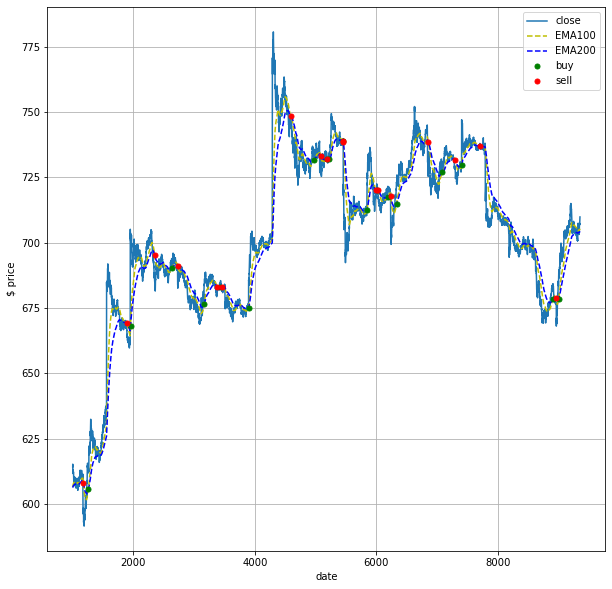

In [50]:
df = convert_to_dataframe(get_database_data())
    
    
df1 = calculate_rsi(df)
df['rsi'] = convert_to_dataframe(df1, columns=['rsi'])

ma_one = 100
ma_two = 200
start_index = 1000
ma_columns = start_strategy(df, ma_one, ma_two)

print_results_from_strategy(df, start_index, 30, 10000, "Tesla")

plot_results(df, ma_columns[0], ma_columns[1], start_index)

In [25]:
int(3.6 / 2)

1